In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
from network import multi_models as models

from sklearn.metrics import recall_score, f1_score, accuracy_score

{1.0: 3}


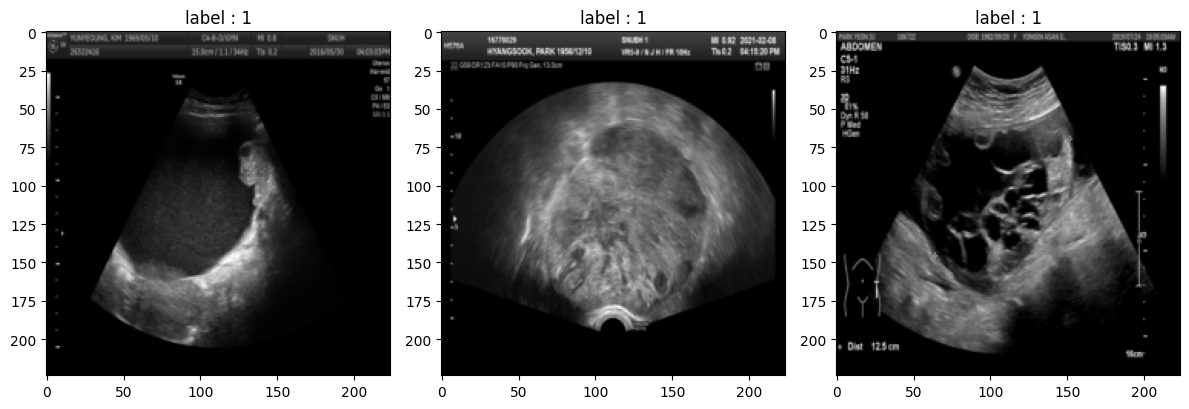

In [2]:
test_dir = '/home/eiden/eiden/DB/octc/data_multi_origin/train'
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    transforms.Grayscale(num_output_channels=3),
])
test_batch = 3
test_dataset = CustomDataset(root_dir = test_dir, transform= test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = test_batch, shuffle= False)

for i, (image, label) in enumerate(test_loader):
    unique, cnts = np.unique(label, return_counts= True)
    print(dict(zip(unique, cnts)))
    plt.figure(figsize= (12, 8))
    plt.subplot(131)
    plt.imshow(image[0,0], cmap ='gray')
    plt.title(f"label : {label[0].int().item()}")
    plt.subplot(132)
    plt.imshow(image[1,0], cmap ='gray')
    plt.title(f"label : {label[1].int().item()}")
    plt.subplot(133)
    plt.imshow(image[2,0], cmap ='gray')
    plt.title(f"label : {label[2].int().item()}")
    plt.tight_layout()
    plt.show()
    break

In [3]:
checkpoint_path = '../../../models/multi/convnext_original_240326/convnext_original_240326_50_e.pt'
checkpoint = torch.load(checkpoint_path)
weight = checkpoint['model_state_dict']
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

test_model = models.pretrained_convnext_multi().to(device)
test_model.load_state_dict(state_dict = weight)
print(f'load complete!! device : {device}')

device : cpu


/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc

correct = 0
total = 0
predicted_labels = []
predicted_scores = []
true_labels = []

In [12]:
with torch.no_grad():
    test_model.eval()
    for _, (inputs, labels) in tqdm(enumerate(test_loader)):
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        outputs = test_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.numpy())
        predicted_scores.extend(torch.softmax(outputs, dim=1).numpy())
        true_labels.extend(labels.numpy())
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # F1 Score 계산
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'F1 Score: {f1:.4f}')

    # Recall 계산
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    print(f'Recall: {recall:.4f}')

    # Specificity 계산 : 특이도는 클래스마다 개별적으로 계산.
    num_classes = len(np.unique(true_labels))
    specificity = []
    for class_label in range(num_classes):
        true_positives = np.sum((np.array(true_labels) == class_label) & (np.array(predicted_labels) == class_label))
        total_actual_class = np.sum(np.array(true_labels) == class_label)
        specificity.append(true_positives / total_actual_class)
    print(f'Specificity per class: {specificity}')

    # ROC Curve 및 AUC 계산
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((np.array(true_labels) == i), predicted_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 모든 클래스에 대한 평균 ROC AUC 계산
    mean_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Mean ROC AUC: {mean_roc_auc:.4f}')

    # ROC Curve 그리기
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

0it [00:00, ?it/s]

Test Accuracy: 0.9657
F1 Score: 0.9825
Recall: 0.9657
Specificity per class: [nan]



/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_822703/3940224420.py:32: RuntimeWarning: invalid value encountered in scalar divide
  specificity.append(true_positives / total_actual_class)


TypeError: list indices must be integers or slices, not tuple

In [7]:
outputs

tensor([1, 1, 1])